In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/'

import pandas as pd

train_data = pd.read_csv(folder_path + "train.tsv", sep="\t", header=None)
valid_data = pd.read_csv(folder_path + "valid.tsv", sep="\t", header=None)
test_data = pd.read_csv(folder_path + "test.tsv", sep="\t", header=None)


Mounted at /content/drive


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


binary_label
0    6602
1    3638
Name: count, dtype: int64
Epoch 1/4
Train Loss: 0.8844, Train Accuracy: 0.5741
Valid Loss: 0.8495, Valid Accuracy: 0.6254

Epoch 2/4
Train Loss: 0.8587, Train Accuracy: 0.5902
Valid Loss: 0.8409, Valid Accuracy: 0.6059

Epoch 3/4
Train Loss: 0.8262, Train Accuracy: 0.6343
Valid Loss: 0.8334, Valid Accuracy: 0.6184

Epoch 4/4
Train Loss: 0.7736, Train Accuracy: 0.6770
Valid Loss: 0.8560, Valid Accuracy: 0.5872



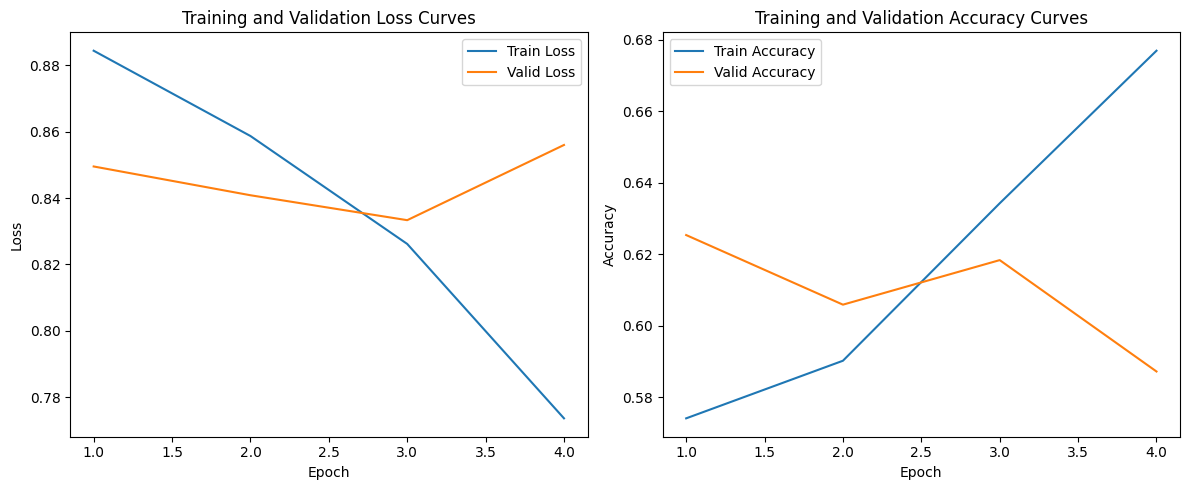


Test Loss: 0.8759
Test Accuracy: 0.5856


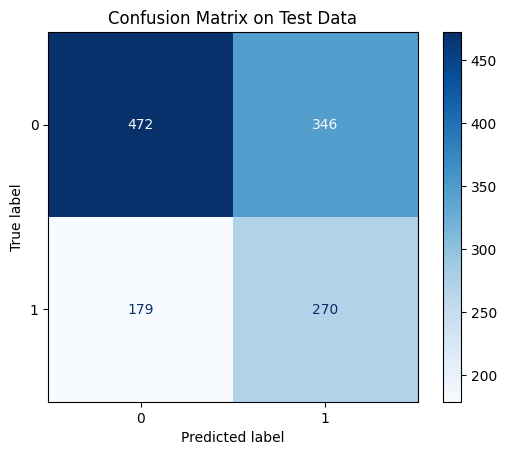

In [4]:
columns = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party",
           "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]
train_data.columns = columns
valid_data.columns = columns
test_data.columns = columns
def binarize_label(label):
    if label in ["true", "mostly-true"]:
        return 1
    return 0
train_data["binary_label"] = train_data["label"].apply(binarize_label)
print(train_data["binary_label"].value_counts())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_neg = train_data["binary_label"].value_counts()[0]
num_pos = train_data["binary_label"].value_counts()[1]
pos_weight = torch.tensor([num_neg / num_pos]).to(device)
valid_data["binary_label"] = valid_data["label"].apply(binarize_label)
test_data["binary_label"] = test_data["label"].apply(binarize_label)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.split()
statements = train_data["statement"].apply(preprocess_text)
all_words = [word for statement in statements for word in statement]
word_counts = Counter(all_words)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common(5000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1
def text_to_indices(text, vocab, max_len=50):
    words = preprocess_text(text)
    indices = [vocab.get(word, vocab["<UNK>"]) for word in words[:max_len]]
    if len(indices) < max_len:
        indices += [vocab["<PAD>"]] * (max_len - len(indices))
    return indices
train_data["indices"] = train_data["statement"].apply(lambda x: text_to_indices(x, vocab))
valid_data["indices"] = valid_data["statement"].apply(lambda x: text_to_indices(x, vocab))
test_data["indices"] = test_data["statement"].apply(lambda x: text_to_indices(x, vocab))

class LIARDataset(Dataset):
    def __init__(self, indices, labels):
        self.indices = torch.tensor(indices, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.indices[idx], self.labels[idx]

train_dataset = LIARDataset(train_data["indices"].tolist(), train_data["binary_label"].tolist())
valid_dataset = LIARDataset(valid_data["indices"].tolist(), valid_data["binary_label"].tolist())
test_dataset = LIARDataset(test_data["indices"].tolist(), test_data["binary_label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

class FakeNewsLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(FakeNewsLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = hidden[-1,:,:]
        hidden = self.dropout(hidden)
        out = self.fc(hidden)
        return out

vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FakeNewsLSTM(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decay LR after 5 epochs

def train_and_evaluate(model, train_loader, valid_loader, epochs=4):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (torch.sigmoid(predictions) > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)
        model.eval()
        valid_loss = 0
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for texts, labels in valid_loader:
                texts, labels = texts.to(device), labels.to(device)
                predictions = model(texts).squeeze(1)
                valid_loss += criterion(predictions, labels).item()
                predicted = (torch.sigmoid(predictions) > 0.5).float()

                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        valid_accuracy = valid_correct / valid_total
        valid_accuracies.append(valid_accuracy)
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}\n")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, epochs + 1), valid_accuracies, label="Valid Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return train_losses, valid_losses, train_accuracies, valid_accuracies

def evaluate_test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).squeeze(1)
            test_loss += criterion(predictions, labels).item()
            predicted = (torch.sigmoid(predictions) > 0.5).float()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nTest Loss: {test_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {correct/total:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix on Test Data')
    plt.show()

train_losses, valid_losses, train_accuracies, valid_accuracies = train_and_evaluate(model, train_loader, valid_loader, epochs=4)
evaluate_test(model, test_loader)
torch.save(model.state_dict(), "fake_news_bilstm_final.pth")